In [ ]:
!pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
stock_data = pd.read_csv("/content/Stock_prediction_LSTM(aadr.us).txt",parse_dates=['Date'], sep=",", index_col = 'Date' )

In [ ]:
df_close = stock_data['Close']

Text(0.5, 1.0, 'aadr stock closing price')

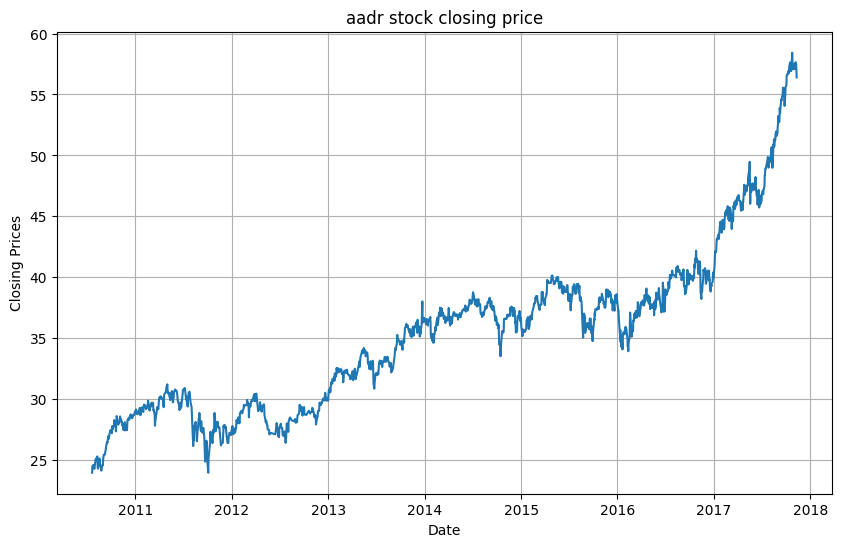

In [ ]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('aadr stock closing price')

In [ ]:
# b. Checking stationarity


In [ ]:
# plot roleing mean -
# we will use the rolling statistics plots along with
# augmented Dickey-Fuller test results.

In [ ]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


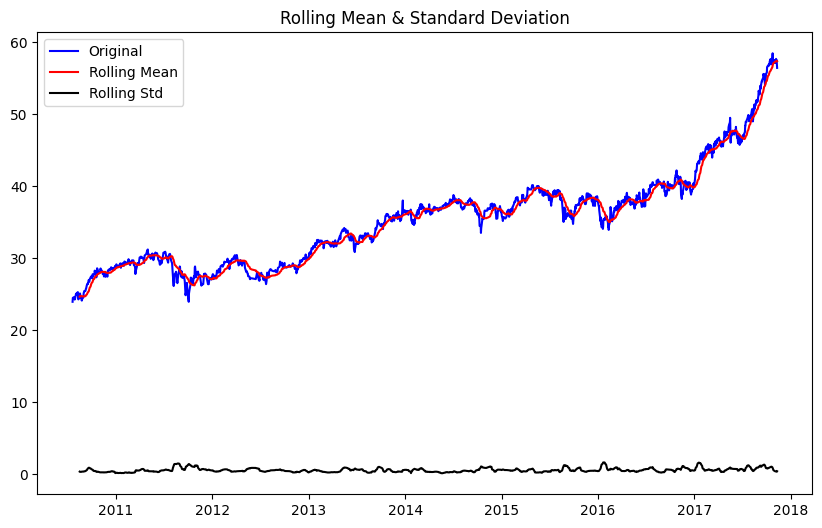

Results of Dickey-Fuller Test:
Test Statistic                    0.732068
p-value                           0.990457
#Lags Used                        4.000000
Number of Observations Used    1560.000000
Critical Value (1%)              -3.434549
Critical Value (5%)              -2.863395
Critical Value (10%)             -2.567757
dtype: float64


In [ ]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

In [ ]:
# c. Making our time series stationary



In [ ]:
# There are three major time series patterns: trend, seasonality, and cycles.
# Trend and cycles are usually combined into a single component,
# leaving us with a trend-cycle component, a seasonal component,
# and a remainder component (containing the rest of the time series).

# To make our time series stationary,
#  principle is to estimate trend and seasonality,
#  and to remove those from the time series.
#  Then, we can apply the forecasting technique
#   (i.e here LSTM), the final step being to convert the forcasted
#   values into the original scale by adding the estimated trend and seasonality.



<Figure size 640x480 with 0 Axes>

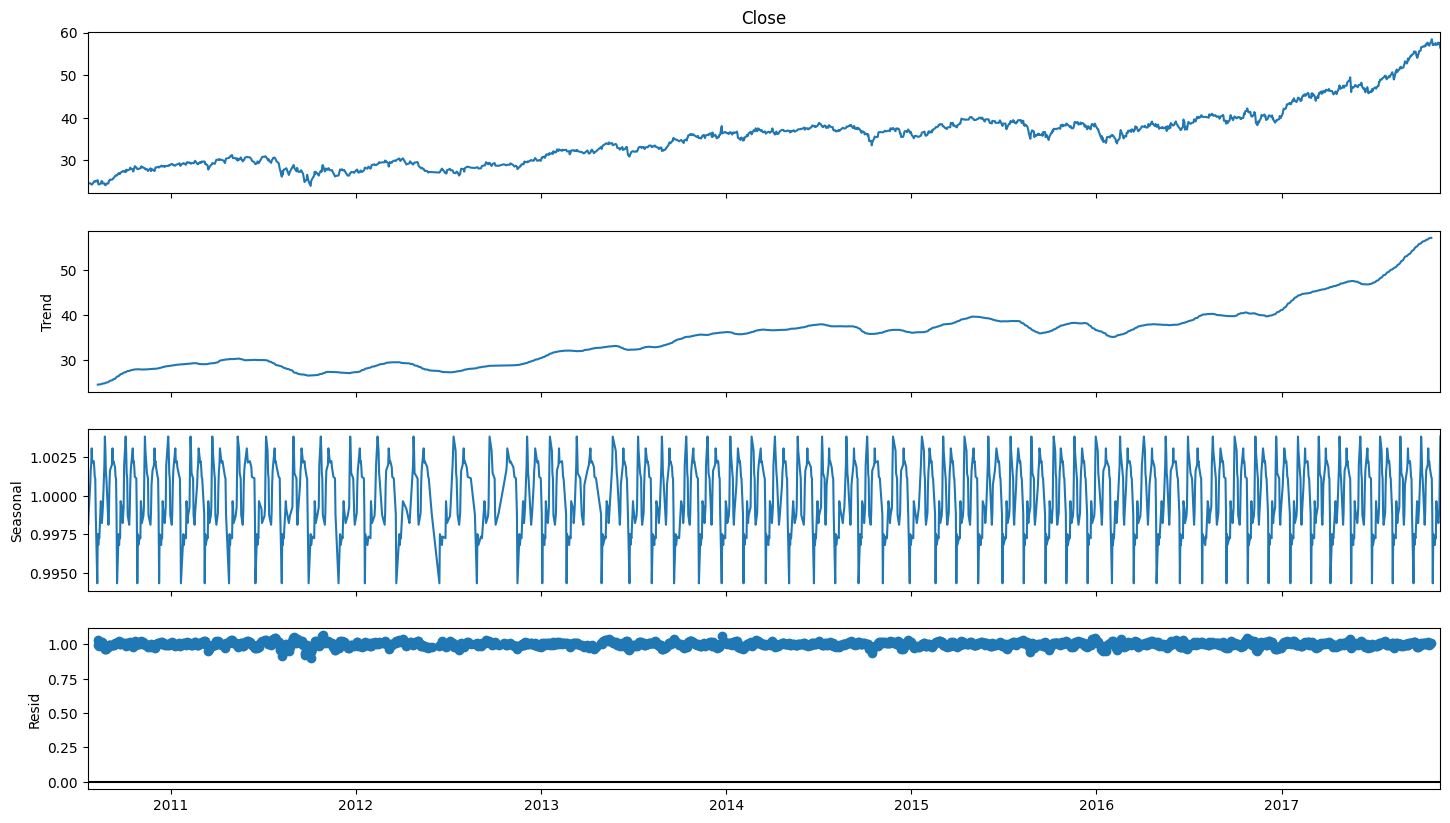

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

In [ ]:
# We start by estimating and eliminating trends.
# As the time series is constantly increasing, we apply a log transform,
# and a square root transform to flatten it.

Text(0.5, 1.0, 'Transformed data')

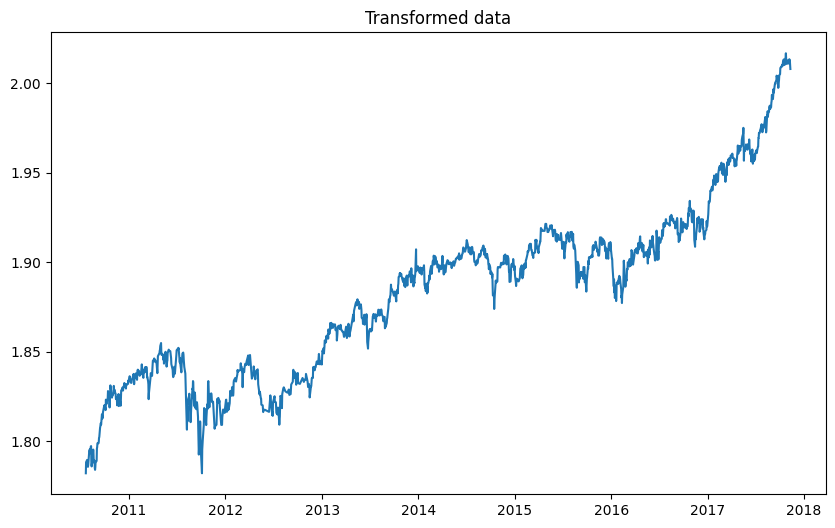

In [ ]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

In [ ]:
# Let's know use one classical method to deal with trend and seasonality:
# differenciating. We take the difference of the observation at a particular
# instant with that at the previous instant.

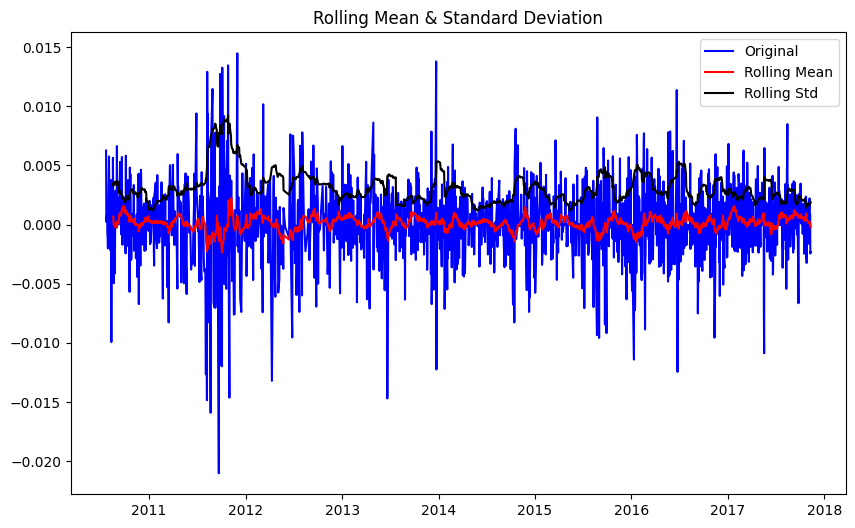

Results of Dickey-Fuller Test:
Test Statistic                  -23.158279
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    1560.000000
Critical Value (1%)              -3.434549
Critical Value (5%)              -2.863395
Critical Value (10%)             -2.567757
dtype: float64


In [ ]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [ ]:
# We obtain significally better results:

# The test statistic is a lot lower than the critical value at 1%.
# Therefore, we can say with more than 99% confidence that this is a
# stationary series. Moreover, as the p-value is inferior to the 5% threshold,
# the null hypothesis is rejected, meaning that the Dickey-Fuller test is verified.
# Thus, the time series is stationary

In [ ]:



# 2. LSTM

In [ ]:
# a. Preprocessing again for LSTM
# We also need to reshape X as the model expects as input a
# training data of shape [samples, timesteps, features]

In [ ]:
# Here, we are working with a univariate series, so the number of feature is one.

# Finally, we choose the number of days on which to base our predictions to be 60 days

In [ ]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [ ]:
# choose the number of days on which to base our predictions
nb_days = 60

n_features = 1

In [ ]:
df_close_shift

,Close
Date,
2010-07-22,0.006257
2010-07-23,0.000228
2010-07-26,0.001002
2010-07-27,-0.000888
2010-07-28,-0.000983
...,...
2017-11-06,0.002208
2017-11-07,-0.001578
2017-11-08,0.000888


In [ ]:
X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [ ]:
X

array([[[ 0.00625728],
        [ 0.00022825],
        [ 0.00100175],
        ...,
        [ 0.00125165],
        [ 0.00375466],
        [-0.00184555]],

       [[ 0.00022825],
        [ 0.00100175],
        [-0.0008877 ],
        ...,
        [ 0.00375466],
        [-0.00184555],
        [-0.00181083]],

       [[ 0.00100175],
        [-0.0008877 ],
        [-0.00098254],
        ...,
        [-0.00184555],
        [-0.00181083],
        [ 0.00018661]],

       ...,

       [[-0.00119243],
        [ 0.00331309],
        [-0.00296464],
        ...,
        [ 0.00021763],
        [ 0.00220772],
        [-0.00157779]],

       [[ 0.00331309],
        [-0.00296464],
        [ 0.00183283],
        ...,
        [ 0.00220772],
        [-0.00157779],
        [ 0.00088754]],

       [[-0.00296464],
        [ 0.00183283],
        [ 0.00073878],
        ...,
        [-0.00157779],
        [ 0.00088754],
        [-0.00244827]]])

In [ ]:
len(X[:-1])

1503

In [ ]:
 len(X[:-2])

1502

In [ ]:
# We split the set between a training set and a test set.
# For the test set, we take the last year (365 days) of the dataset.

In [ ]:
#Split the data set between the training set and the test set (- 365 from back)
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

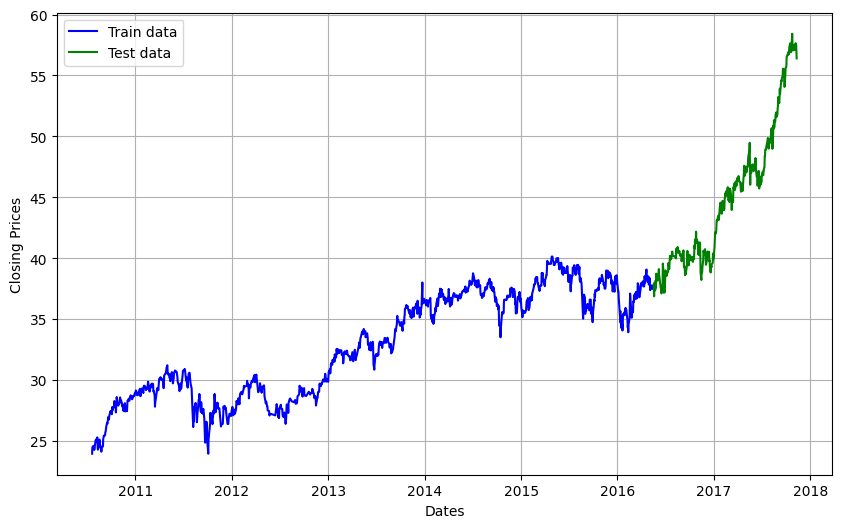

In [ ]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [ ]:
# c. Implementing the model

In [ ]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [ ]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 3.0249e-05 - mean_absolute_error: 0.0042
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.3073e-05 - mean_absolute_error: 0.0026
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3063e-05 - mean_absolute_error: 0.0025
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.1337e-05 - mean_absolute_error: 0.0024
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2677e-05 - mean_absolute_error: 0.0025
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0533e-05 - mean_absolute_error: 0.0023
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.2409e-05 - mean_absolute_error: 0.0025
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1072e-05 - mean_absolute_error: 0.0024
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.1437e-05 - mean_absolute_error: 0.0024
Epoch 10/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.2762e-05 - mean_absolute_error: 0.0025

In [ ]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0637e-05 - mean_absolute_error: 0.0024
Test MSE: 8.058296771196183e-06
Test MAE: 0.0021196738816797733


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


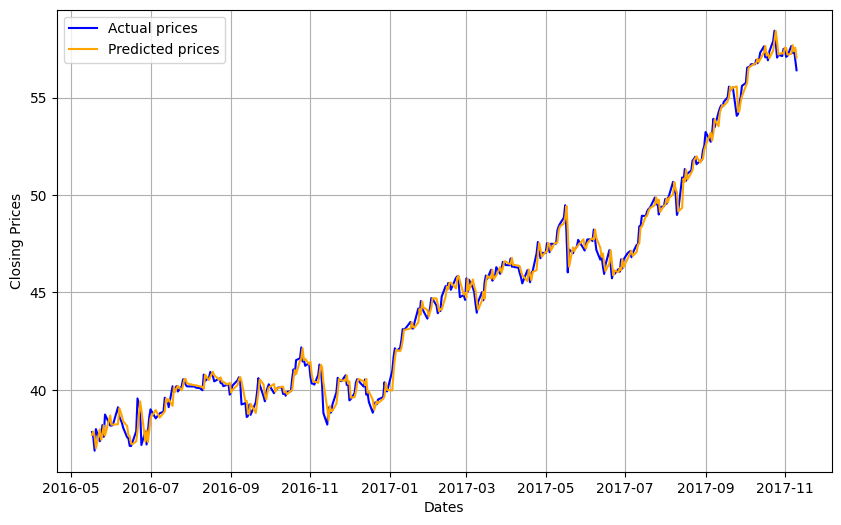

In [ ]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]



# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
# plt.title(company + ' Stock Price')

plt.legend()

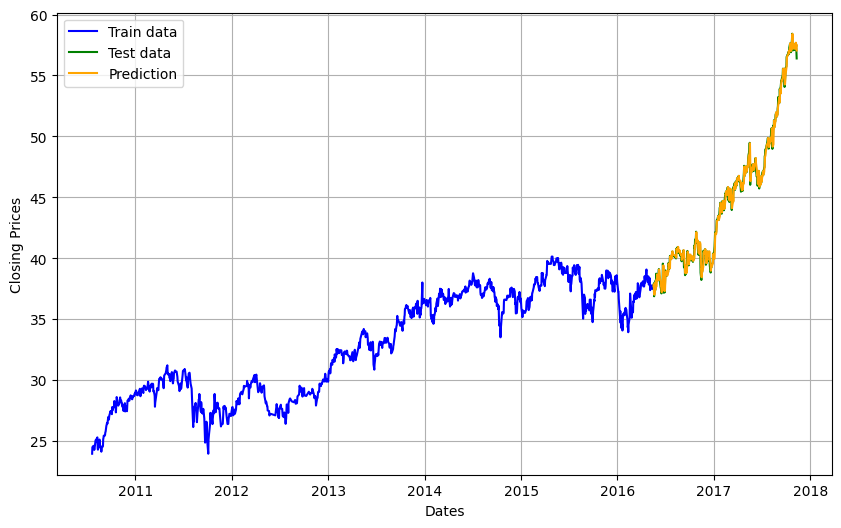

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
# plt.title(company + ' Stock Price')
plt.legend()